In [92]:
#importing basic python Libraries for data science work + networkX
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [93]:
#Importing preprocessing model support libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [94]:
# importing models to be deployed and other required libraries

#Linear Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

#Other Regression Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# importing the GridSearchCV class from model_selection submodule of scikit learn to cross validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from tempfile import mkdtemp

#To save the models
from sklearn.externals import joblib
import pickle

In [95]:
%%time

#Importing the pre-processed clean data. Please change path to the file location of the file created by preprocessing

master_df = pd.read_csv('pre_processed_data.csv', low_memory = False)

Wall time: 26.3 s


In [96]:
master_df.head()

,Unnamed: 0,link_id,source_id,destination_id,route_direction,weekday,hour,rush_hour,winter,visibility_km,...,mean_temp_celcius,rain_mm,snow_cm,snow_on_ground_cm,wind_speed_kmh,wind_direction,weather_conditions,distance_m,speed_kmh,travel_time_sec
0,0,LSD_89-87,89,87,180,1,4,0,1,8.1,...,2.0,16.8,0.2,0.0,18.0,2.0,5,308,13.044706,85
1,1,LSD_89-87,89,87,180,1,4,0,1,8.1,...,2.0,16.8,0.2,0.0,18.0,2.0,5,308,20.160000,55
2,2,LSD_89-87,89,87,180,1,4,0,1,8.1,...,2.0,16.8,0.2,0.0,18.0,2.0,5,308,34.650000,32
3,3,LSD_89-87,89,87,180,1,4,0,1,8.1,...,2.0,16.8,0.2,0.0,18.0,2.0,5,308,15.616901,71
4,4,LSD_89-87,89,87,180,1,4,0,1,8.1,...,2.0,16.8,0.2,0.0,18.0,2.0,5,308,32.611765,34


In [97]:
#Drop unnnamed extra column that was created in the process
master_df.drop(['Unnamed: 0'], axis=1, inplace = True) 

In [98]:
master_df.head()

,link_id,source_id,destination_id,route_direction,weekday,hour,rush_hour,winter,visibility_km,humidity_percentage,mean_temp_celcius,rain_mm,snow_cm,snow_on_ground_cm,wind_speed_kmh,wind_direction,weather_conditions,distance_m,speed_kmh,travel_time_sec
0,LSD_89-87,89,87,180,1,4,0,1,8.1,95.0,2.0,16.8,0.2,0.0,18.0,2.0,5,308,13.044706,85
1,LSD_89-87,89,87,180,1,4,0,1,8.1,95.0,2.0,16.8,0.2,0.0,18.0,2.0,5,308,20.160000,55
2,LSD_89-87,89,87,180,1,4,0,1,8.1,95.0,2.0,16.8,0.2,0.0,18.0,2.0,5,308,34.650000,32
3,LSD_89-87,89,87,180,1,4,0,1,8.1,95.0,2.0,16.8,0.2,0.0,18.0,2.0,5,308,15.616901,71
4,LSD_89-87,89,87,180,1,4,0,1,8.1,95.0,2.0,16.8,0.2,0.0,18.0,2.0,5,308,32.611765,34


In [99]:
#Creating a copy of original data for modeling 
model_df = master_df.copy()

In [100]:
#Dropping columns that are categorical to deploy linear regression on features

model_df.drop(['source_id', 'destination_id'], axis=1, inplace = True) 

## Checking for Linear Regression Assumptions

In [101]:
#Checking colinearity in the data
corr_df = model_df.corr()

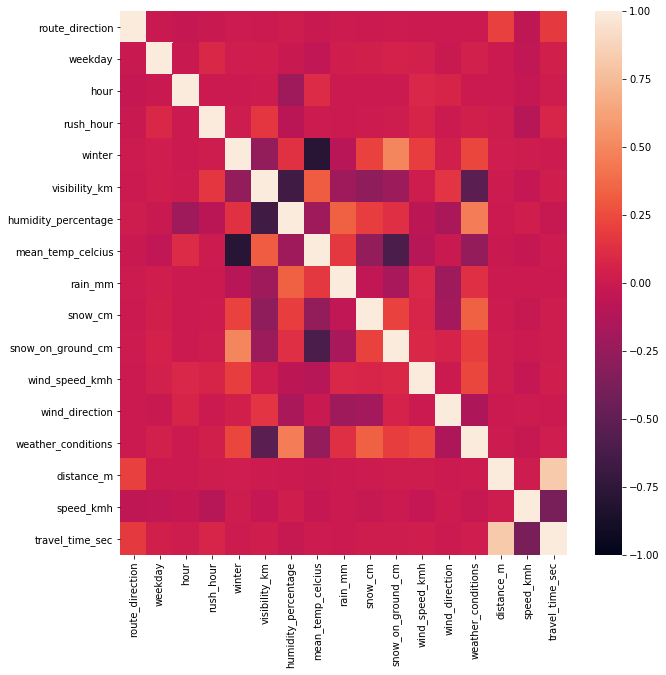

In [102]:
#display heat map to show colinearity
plt.figure(figsize = (10,10))
sns.heatmap(corr_df,vmin=-1, vmax=1)
sns.heatmap;

We see the `mean_temp_celcius` and `humidity_percentage` has some strong linear relationships with other features so we will drop these and check the correlation heatmap again.

In [103]:
#Drop highly correlated columns 
model_df.drop(['mean_temp_celcius', 'humidity_percentage'], axis=1, inplace = True) 

In [104]:
#Check colinearity in the data again
corr_df1 = model_df.corr()

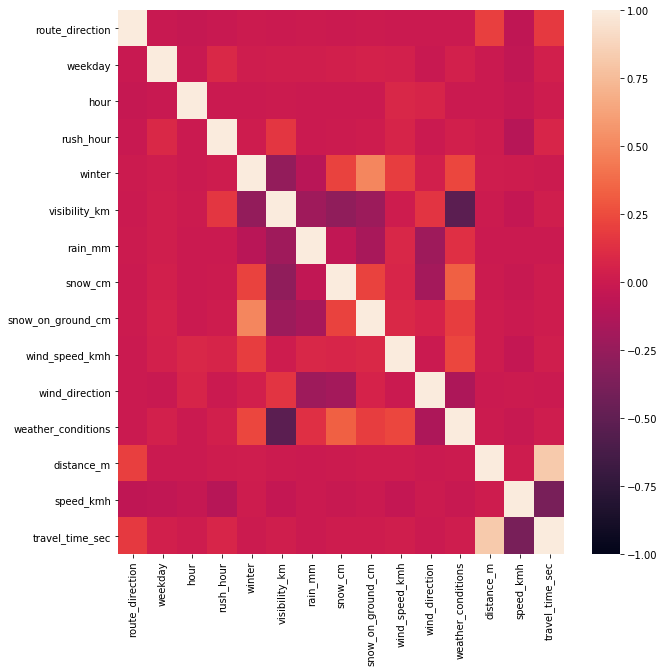

In [105]:
#display heat map to show colinearity again
plt.figure(figsize = (10,10))
sns.heatmap(corr_df1,vmin=-1, vmax=1)
sns.heatmap;

Data seems ready for train-test split and feature engineering afterwards.

---
## Train-Test Split
---

In [106]:
# assign features to target(y) and data(X) and split the data into train and test

X = model_df.loc[:, model_df.columns != 'travel_time_sec']
y = model_df['travel_time_sec']

X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state = 8)

---

## Feature Engineering

---

In [107]:
#Lets add a mean & std of hourly speed and travel time by each segment as feature to our train and test datasets

X_rem["mean_speed_on_segment"] = round(X_rem.groupby(['link_id', 'hour'])["speed_kmh"].transform('mean'),3)
#X_rem["std_speed_on_segment"] = round(X_rem.groupby(['link_id', 'hour'])["speed_kmh"].transform('std'),3)

C:\Users\safiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
X_rem.head()

,link_id,route_direction,weekday,hour,rush_hour,winter,visibility_km,rain_mm,snow_cm,snow_on_ground_cm,wind_speed_kmh,wind_direction,weather_conditions,distance_m,speed_kmh,mean_speed_on_segment
1054512,LPr_27-28,360,0,13,0,0,48.3,0.0,0.0,0.0,19.0,20.0,2,1435,36.638298,25.933
7529244,LPa_15-17,180,0,8,1,0,48.3,1.0,0.0,0.0,10.0,20.0,2,2937,29.047253,23.486
6585704,LND_1E-1C,270,0,10,1,0,19.3,6.4,0.0,0.0,34.0,23.0,3,561,51.784615,31.710
707907,LSD_31-32,360,0,18,1,1,8.1,7.2,0.2,0.0,20.0,3.0,5,982,47.772973,29.746
3374748,LAy_66-65,360,1,14,0,1,2.4,17.6,0.0,18.0,4.0,21.0,5,195,41.294118,19.742


In [109]:
temp_df = pd.DataFrame(X_rem[['link_id', 'hour', 'mean_speed_on_segment']])
temp_df = temp_df.groupby(['link_id', 'hour'], as_index=False)['mean_speed_on_segment'].mean()
temp_df

,link_id,hour,mean_speed_on_segment
0,LAy_65-67,0,22.557
1,LAy_65-67,1,24.112
2,LAy_65-67,2,25.096
3,LAy_65-67,3,27.177
4,LAy_65-67,4,25.556
...,...,...,...
5251,LVH_32-28,19,38.251
5252,LVH_32-28,20,37.836
5253,LVH_32-28,21,38.580
5254,LVH_32-28,22,38.099


In [110]:
#Lets add a mean & std speed by each segment as feature to our test dataset
X_test = X_test.merge(temp_df, how = 'left', on = ['link_id', 'hour'])

In [111]:
X_rem.head()

,link_id,route_direction,weekday,hour,rush_hour,winter,visibility_km,rain_mm,snow_cm,snow_on_ground_cm,wind_speed_kmh,wind_direction,weather_conditions,distance_m,speed_kmh,mean_speed_on_segment
1054512,LPr_27-28,360,0,13,0,0,48.3,0.0,0.0,0.0,19.0,20.0,2,1435,36.638298,25.933
7529244,LPa_15-17,180,0,8,1,0,48.3,1.0,0.0,0.0,10.0,20.0,2,2937,29.047253,23.486
6585704,LND_1E-1C,270,0,10,1,0,19.3,6.4,0.0,0.0,34.0,23.0,3,561,51.784615,31.710
707907,LSD_31-32,360,0,18,1,1,8.1,7.2,0.2,0.0,20.0,3.0,5,982,47.772973,29.746
3374748,LAy_66-65,360,1,14,0,1,2.4,17.6,0.0,18.0,4.0,21.0,5,195,41.294118,19.742


In [112]:
X_test.head()

,link_id,route_direction,weekday,hour,rush_hour,winter,visibility_km,rain_mm,snow_cm,snow_on_ground_cm,wind_speed_kmh,wind_direction,weather_conditions,distance_m,speed_kmh,mean_speed_on_segment
0,LND_1D-1M,270,1,18,1,0,48.3,6.0,0.0,0.0,22.0,25.0,2,534,48.060000,41.636
1,LND_1M-1A,270,1,12,0,0,48.3,0.2,0.0,0.0,22.0,20.0,2,849,37.733333,42.942
2,LND_1F-1G,270,0,14,0,0,48.3,0.0,0.0,0.0,10.0,20.0,2,570,55.459460,40.167
3,LSD_31-30,180,1,9,1,1,11.3,17.0,0.0,0.0,11.0,6.0,3,1896,30.336000,25.773
4,LND_1C-1D,270,1,11,0,1,24.1,0.0,0.2,10.0,8.0,18.0,6,594,64.800000,42.039


## Mean-time by hour on each each segment 


In [113]:
#time added back to calculate mean time to add as a feature24
X_rem['time'] = y_rem

C:\Users\safiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [114]:
#Lets add a mean & std speed and travel time by each segment as feature to our train and test datasets

X_rem["mean_time_on_segment"] = round(X_rem.groupby(['link_id', 'hour'])["time"].transform('mean'),3)


C:\Users\safiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [115]:
#tempdf to link up speed by hour and link_id
temp_df = pd.DataFrame(X_rem[['link_id', 'hour', 'mean_time_on_segment']])
temp_df = temp_df.groupby(['link_id', 'hour'], as_index=False)['mean_time_on_segment'].mean()
temp_df['mean_time_on_segment']

0        37.423
1        35.582
2        33.951
3        31.839
4        33.306
         ...   
5251    119.971
5252    124.082
5253    119.243
5254    122.215
5255    117.697
Name: mean_time_on_segment, Length: 5256, dtype: float64

In [116]:
temp_df.head()

,link_id,hour,mean_time_on_segment
0,LAy_65-67,0,37.423
1,LAy_65-67,1,35.582
2,LAy_65-67,2,33.951
3,LAy_65-67,3,31.839
4,LAy_65-67,4,33.306


In [117]:
#Lets merge it with our test set to add mean & std speed by each segment and hour as feature 
X_test = X_test.merge(temp_df, how = 'left', on = ['link_id', 'hour'])

In [118]:
X_rem.fillna(method = 'bfill', inplace = True)
X_test.fillna(method = 'bfill', inplace = True)

C:\Users\safiu\Anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [119]:
X_test.head()

,link_id,route_direction,weekday,hour,rush_hour,winter,visibility_km,rain_mm,snow_cm,snow_on_ground_cm,wind_speed_kmh,wind_direction,weather_conditions,distance_m,speed_kmh,mean_speed_on_segment,mean_time_on_segment
0,LND_1D-1M,270,1,18,1,0,48.3,6.0,0.0,0.0,22.0,25.0,2,534,48.060000,41.636,52.638
1,LND_1M-1A,270,1,12,0,0,48.3,0.2,0.0,0.0,22.0,20.0,2,849,37.733333,42.942,83.597
2,LND_1F-1G,270,0,14,0,0,48.3,0.0,0.0,0.0,10.0,20.0,2,570,55.459460,40.167,57.043
3,LSD_31-30,180,1,9,1,1,11.3,17.0,0.0,0.0,11.0,6.0,3,1896,30.336000,25.773,282.256
4,LND_1C-1D,270,1,11,0,1,24.1,0.0,0.2,10.0,8.0,18.0,6,594,64.800000,42.039,55.490


In [120]:
#Drop Excess columns to feed into the model
X_rem.drop(['link_id', 'speed_kmh', 'time'], axis=1, inplace = True) 
X_test.drop(['link_id', 'speed_kmh'], axis=1, inplace = True) 

C:\Users\safiu\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [121]:
X_rem.head()

,route_direction,weekday,hour,rush_hour,winter,visibility_km,rain_mm,snow_cm,snow_on_ground_cm,wind_speed_kmh,wind_direction,weather_conditions,distance_m,mean_speed_on_segment,mean_time_on_segment
1054512,360,0,13,0,0,48.3,0.0,0.0,0.0,19.0,20.0,2,1435,25.933,217.116
7529244,180,0,8,1,0,48.3,1.0,0.0,0.0,10.0,20.0,2,2937,23.486,484.546
6585704,270,0,10,1,0,19.3,6.4,0.0,0.0,34.0,23.0,3,561,31.710,76.922
707907,360,0,18,1,1,8.1,7.2,0.2,0.0,20.0,3.0,5,982,29.746,133.495
3374748,360,1,14,0,1,2.4,17.6,0.0,18.0,4.0,21.0,5,195,19.742,41.810


In [122]:
X_test.head()

,route_direction,weekday,hour,rush_hour,winter,visibility_km,rain_mm,snow_cm,snow_on_ground_cm,wind_speed_kmh,wind_direction,weather_conditions,distance_m,mean_speed_on_segment,mean_time_on_segment
0,270,1,18,1,0,48.3,6.0,0.0,0.0,22.0,25.0,2,534,41.636,52.638
1,270,1,12,0,0,48.3,0.2,0.0,0.0,22.0,20.0,2,849,42.942,83.597
2,270,0,14,0,0,48.3,0.0,0.0,0.0,10.0,20.0,2,570,40.167,57.043
3,180,1,9,1,1,11.3,17.0,0.0,0.0,11.0,6.0,3,1896,25.773,282.256
4,270,1,11,0,1,24.1,0.0,0.2,10.0,8.0,18.0,6,594,42.039,55.490


### Reason to drop `speed_kmh` as a  feature and adding `mean_speed_on_segment`: 

Though speed plays a vital role in calculating travel time for any given route, when predicting in real time the future trip speed will not be known to the model. Therefore we created the mean speed and standard deviation based on hour of the day and binary weekday which will be easily extracted from cell phone or computer being used to calculate the travel time. This integrates the historical information that will be stored in the application linked with each road segment.

In [123]:
print('X_rem Shape: ', X_rem.shape)
print('y_rem Shape: ', y_rem.shape)
print('X_test Shape: ', X_test.shape)
print('y_test Shape: ', y_test.shape)

X_rem Shape:  (8921364, 15)
y_rem Shape:  (8921364,)
X_test Shape:  (2230341, 15)
y_test Shape:  (2230341,)


---- 

# Base Line Modelling 

---

### LINEAR REGRESSION USING SCIKIT LEARN

---

### Linear Regression on Raw data


In [34]:
#linear regression on raw data
regressor = LinearRegression(n_jobs = -1, normalize = False, fit_intercept = True)  
regressor.fit(X_rem, y_rem)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

#### Predictions

In [35]:
#Predicting values of test set
y_pred_raw = regressor.predict(X_test)

In [36]:
#Saving results in results_raw
results_raw = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_raw})

In [37]:
#Creating a subset of predictions to display results
raw_results_display = results_raw.head(20)
raw_results_display

,Actual,Predicted
8769907,40,56.489916
9126561,81,88.488697
6324487,37,50.982081
394833,225,280.759575
6780176,33,57.435555
7713231,41,56.658318
155736,41,99.712415
10057356,197,168.788959
7063609,110,87.583688
220635,37,48.951033


In [38]:
#Checking if the predicted time and actual time shares same measure of central tendency
print('Mean: \n', results_raw.mean(), '\n Standard Deviation: \n', results_raw.std())

Mean: 
 Actual       126.531439
Predicted    126.557029
dtype: float64 
 Standard Deviation: 
 Actual       112.577939
Predicted     99.810236
dtype: float64


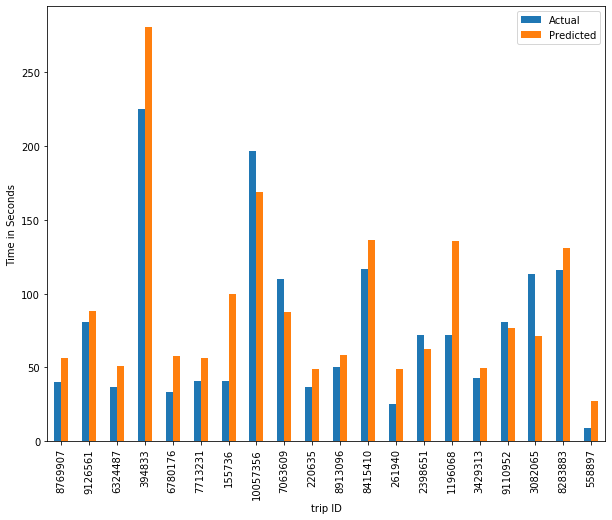

In [39]:
#Displaying results for the visual comparison
raw_results_display.plot(kind='bar',figsize=(10,8))
plt.xlabel('trip ID')
plt.ylabel('Time in Seconds')
plt.show()

#### Scoring

In [40]:
#Checking all key metrics to evaluate model

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_raw))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_raw))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_raw)))
print('R square:', metrics.r2_score(y_test,y_pred_raw))

Mean Absolute Error: 32.68519563685006
Mean Squared Error: 2713.5469968319017
Root Mean Squared Error: 52.091717161482606
R square: 0.7858929548979349


### Comments for DecisionTree Regression base line model:

The model was able to explain the variance of 78.59% with the mean absolute error of only 32.68 seconds. According to the first 20 results displayed our model was able to predict most of the trips with a decent accuracy over varying distances. This is a promising result but since we know all the independent variables do not have a linear relationship with our dependant variable we will rely more so on other regression models such as `DecisionTree Regressor`, `RandomForest Regressor` and `GradientBoosting Regressor`.

--- 

### Additional Models: 

#### 1) Decision Tree Regressor
#### 2) Random Forest Regressor
#### 3) GradientBoosting Regressor

---

# Decision Tree Regressor


In [110]:
%%time
# We will try with a range of max_depth values to see where r2 and MAE are the lowest for our test data. 
max_depth = np.arange(5,30,2)
r2 = []
mae = []

for depth in max_depth:
    dt_reg = DecisionTreeRegressor(max_depth= depth, random_state = 8)
    dt_reg.fit(X_rem, y_rem)
    dt_y_pred_raw = dt_reg.predict(X_test)
    r2.append(metrics.r2_score(y_test, dt_y_pred_raw))
    mae.append(metrics.mean_absolute_error(y_test, dt_y_pred_raw))



Wall time: 16min 25s


In [129]:
# making a df to compare results 
dt_eval = pd.DataFrame(data = [max_depth, r2, mae]).T
dt_eval.columns = ['max_depth', 'R2', 'MAE']

#displaying results of DecisionTree Regression
dt_eval

,max_depth,R2,MAE
0,5.0,0.783178,32.870273
1,7.0,0.790231,32.316902
2,9.0,0.795600,31.867263
3,11.0,0.799715,31.500042
4,13.0,0.804228,31.128635
5,15.0,0.809022,30.714894
6,17.0,0.813704,30.302869
7,19.0,0.816920,29.985614
8,21.0,0.818408,29.803200
9,23.0,0.818674,29.724480


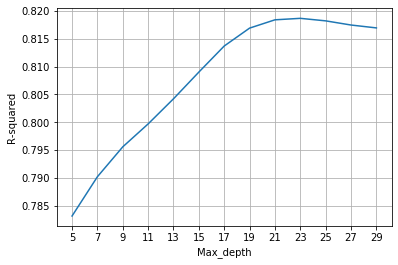

In [125]:
#Showing visual relationship between R-squared and max_depth parameter
plt.figure()
plt.plot(dt_eval.max_depth, dt_eval.R2)
plt.xlabel('Max_depth')
plt.ylabel('R-squared')
plt.grid()
plt.xticks(dt_eval.max_depth)
plt.show()

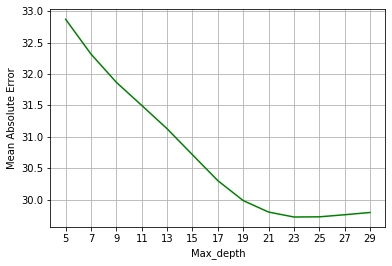

In [128]:
#Showing visual relationship between MAE and max_depth parameter
plt.figure()
plt.plot(dt_eval.max_depth, dt_eval.MAE, c = 'g')
plt.xlabel('Max_depth')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.xticks(dt_eval.max_depth)
plt.show()

#### Predictions

In [116]:
#Predict using DT regression
dt_y_pred_raw = dt_reg.predict(X_test)

In [117]:
#Saving results in results_raw
dt_results_raw = pd.DataFrame({'Actual': y_test, 'Predicted': dt_y_pred_raw})

In [118]:
#Creating a subset of predictions to display results visually for a comparison
dt_raw_results_display = dt_results_raw.head(20)
dt_raw_results_display

,Actual,Predicted
8769907,40,55.583333
9126561,81,76.727273
6324487,37,55.272727
394833,225,244.875000
6780176,33,58.088235
7713231,41,59.518519
155736,41,105.217391
10057356,197,178.500000
7063609,110,75.023810
220635,37,48.395238


#### Scoring

###### Test score

In [119]:
#Test Scores for DecisionTreeRegressor with max_depth = 29
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, dt_y_pred_raw))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, dt_y_pred_raw))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, dt_y_pred_raw)))
print('R square:', metrics.r2_score(y_test, dt_y_pred_raw))

Mean Absolute Error: 29.79649970536666
Mean Squared Error: 2319.878499053247
Root Mean Squared Error: 48.165117035602094
R square: 0.8169545871112567


###### Training Score

In [120]:
#training scores to check for any overfitting
dt_y_rem_accuracy = dt_reg.predict(X_rem)

In [123]:
#Training Scores for DecisionTreeRegressor with max_depth = 29
print('Mean Absolute Error:', metrics.mean_absolute_error(y_rem, dt_y_rem_accuracy))  
print('Mean Squared Error:', metrics.mean_squared_error(y_rem, dt_y_rem_accuracy))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_rem, dt_y_rem_accuracy)))
print('R square:', metrics.r2_score(y_rem, dt_y_rem_accuracy))

Mean Absolute Error: 27.341751303241427
Mean Squared Error: 1928.1789109765696
Root Mean Squared Error: 43.911034045858784
R square: 0.8477224321438723


In [ ]:
#Uncomment this code and run to sneak peak inside the decision tree
'''from sklearn.tree import plot_tree
# size for our tree figure
fig, ax = plt.subplots(figsize=(100,50))

plot_tree(dt_reg,
          feature_names=X_rem.columns,
          rounded=True,
          impurity=False,
          filled=True,
          ax=ax,
          fontsize=12);'''

### Comments for DecisionTree Regression base line model:

As we can see as we increase the `max_depth` parameter starting from `5` to `29` our `R2` and `MAE` improve at a marginally diminishing rate. After `max_depth = 23`, R-squared and Mean Absolute Error both key metrics for our evaluation begin to increase slightly which means we have found a minimum poin for our key metrics. Though going even deeper might give us a better result but that will come at the expense of computational power and a risk of overfitting. This will give us an idea regarding randomforest regression hyperparameter tuning should not test values above 25 for max_depth.


----

--- 
### Random Forest Regression
---

In [52]:
%%time

#instantiate, fit and predict random forest regression with max_depth = 10 and n_estimators= 10 

random_forest_reg = RandomForestRegressor(max_depth=10, n_estimators = 10, random_state=8, n_jobs = -1)
random_forest_reg.fit(X_rem, y_rem)

Wall time: 3min 45s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False)

#### Scoring

In [53]:
#saving test scores
rf_reg_y_pred = random_forest_reg.predict(X_test)

In [54]:
#saving training score
rf_reg_y_rem_score = random_forest_reg.predict(X_rem)

###### Test Score

In [55]:
#test scores
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, rf_reg_y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, rf_reg_y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, rf_reg_y_pred)))
print('R square:', metrics.r2_score(y_test, rf_reg_y_pred))

Mean Absolute Error: 31.569248517664025
Mean Squared Error: 2544.0998994727165
Root Mean Squared Error: 50.43907115989267
R square: 0.799262842118998


###### Training Score

In [56]:
#training scores
print('Mean Absolute Error:', metrics.mean_absolute_error(y_rem, rf_reg_y_rem_score))  
print('Mean Squared Error:', metrics.mean_squared_error(y_rem, rf_reg_y_rem_score))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_rem, rf_reg_y_rem_score)))
print('R square:', metrics.r2_score(y_rem, rf_reg_y_rem_score))

Mean Absolute Error: 31.56928214265567
Mean Squared Error: 2538.6476088708323
Root Mean Squared Error: 50.38499388578739
R square: 0.7995107812237026


---
#### RandomForestRegressor Model 2

In [57]:
%%time
#repeating the steps above with max_depth = 20 and n_estimators = 20

random_forest_reg2 = RandomForestRegressor(max_depth=20, n_estimators = 20, random_state=8, n_jobs = -1)
random_forest_reg2.fit(X_rem, y_rem)

Wall time: 10min 33s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False)

#### Scoring (Test set)

In [59]:
rf_reg_y_pred2 = random_forest_reg2.predict(X_test)

In [60]:
#test scores for 20-20 max_depth and n_estimators
print('Mean Absolute Error:', metrics.mean_absolute_error(y_rem, rf_reg_y_pred2))  
print('Mean Squared Error:', metrics.mean_squared_error(y_rem, rf_reg_y_pred2))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_rem, rf_reg_y_pred2)))
print('R square:', metrics.r2_score(y_rem, rf_reg_y_pred))

Mean Absolute Error: 29.439334430681125
Mean Squared Error: 2232.538133058724
Root Mean Squared Error: 47.24974214806599
R square: 0.8238460055031449


### Comments for base line RandomForestRegression:

RandomForest Regression showed significant improvement over Linear regression as expected. Mean Absolute Error of under 30 seconds is very promising considering our dependant variable is continous. It is also a slight improvement over decision tree regression. Due to a small magnitude of improvement even with 20 estimators we can safely say each decision tree on its own is not very different from the others in the random forest. Regardsless, this will provide a significant base for our hyperparameter tuning in the future for our RandomForest Regression model.


---

---
### Gradient Boosting
---

#### GradientBoostingRegressor with loss = 'ls' (Least Squares)

In [62]:
%%time

#instantiate, fit, predict gradient boosting regression with max_depth = 10, n_estimators= 20 & loss = 'ls'(least squared)

gb_reg = GradientBoostingRegressor(max_depth = 10, n_estimators = 20, random_state = 8, verbose = 1)
gb_reg.fit(X_rem,y_rem)
gb_reg_y_pred = gb_reg.predict(X_test)

      Iter       Train Loss   Remaining Time 
         1       10742.3638           20.66m
         2        9186.9776           19.52m
         3        7925.8362           18.43m
         4        6903.0435           17.33m
         5        6074.0237           16.25m
         6        5401.3845           14.94m
         7        4855.9715           13.87m
         8        4413.1704           12.79m
         9        4053.5918           11.74m
        10        3761.6116           10.68m
        20        2639.6943            0.00s
Wall time: 21min 43s


#### Scoring (Test set)

In [63]:
#test scores Gradient Boosting with loss = 'ls' and 20/20 estimators and depth
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, gb_reg_y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, gb_reg_y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, gb_reg_y_pred)))
print('R square:', metrics.r2_score(y_test, gb_reg_y_pred))

Mean Absolute Error: 32.54325356481955
Mean Squared Error: 2648.7433971422993
Root Mean Squared Error: 51.465944051793116
R square: 0.7910061544326092


---
#### GradientBoostingRegressor with loss = 'lad' (Least Absolute Deviation)
---

In [74]:
%%time

#instantiate+fit+predict GradientBoostingRegressor w/ max_depth=10, n_estimators=20 & loss='lad'(least absolute deviation)

gb_reg2 = GradientBoostingRegressor(max_depth = 10, n_estimators = 20, loss='lad', random_state = 8, verbose = 2)
gb_reg2.fit(X_rem,y_rem)
gb_reg2_y_pred = gb_reg2.predict(X_test)

      Iter       Train Loss   Remaining Time 
         1          72.3817           23.67m
         2          66.5469           23.18m
         3          61.3965           22.27m
         4          56.8817           21.07m
         5          52.9356           19.81m
         6          49.5181           18.79m
         7          46.5673           17.68m
         8          44.0259           16.53m
         9          41.8390           15.34m
        10          39.9934           14.06m
        11          38.4401           12.71m
        12          37.1415           11.47m
        13          36.0400           10.05m
        14          35.1193            8.65m
        15          34.3543            7.21m
        16          33.7043            5.79m
        17          33.1675            4.34m
        18          32.7176            2.89m
        19          32.3414            1.45m
        20          32.0257            0.00s
Wall time: 29min 25s


#### Scoring (Test Set)

In [75]:
#test scores for Gradient Boosting with loss = 'lad' and 20/20 estimators and depth
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, gb_reg2_y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, gb_reg2_y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, gb_reg2_y_pred)))
print('R square:', metrics.r2_score(y_test, gb_reg2_y_pred))

Mean Absolute Error: 32.01899354924774
Mean Squared Error: 3037.5514874882306
Root Mean Squared Error: 55.113986314620995
R square: 0.7603280230300813


### Comments Baseline GradientBoosting Regressor:

GradientBoosting Regression did not provide a very promising result which is even worse than the linear regression. This maybe due to the fact that there is a range of parameters that will effect its performance. We will focus more on gradientboosting when we try Gridsearch Cross-Validation for the hyperparameter tuning for GradientBoosting Regression. This will serve as a good indication as a worst case scenerio and baseline model.

---

---
# GridSearch Cross Validation (CV) with ML Pipelines to find the best hyperparameters for each model
---

### Linear Regression GridSearch CrossValidation Pipeline
---

#### Pipeline Set up

In [76]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Setting up a pipeline
my_pipeline = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()), ('model', LinearRegression())], memory=cachedir)

#### Parameter Grid Set up

In [77]:
#Setting up Parameter grid to find the results for best Linear Regression parameters 
# We will run it against PCA and No PCA variants of Linear regression

linreg_param_grid = [
    
    #without PCA
    {'scaler': [StandardScaler()],
     'dim_reducer': [None],
     'model': [Lasso(), Ridge()],
    'model__alpha': [0.0005 ,0.001, 0.01,0.04, 0.08, 1]},
    
    #with PCA
    {'scaler': [StandardScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [3,8,12],
     'model': [Lasso(), Ridge()],
    'model__alpha': [0.0005 ,0.001, 0.01,0.04, 0.08, 1]}
]

#### Instantiate the grid search CV with 3 folds

In [78]:
# Instantiate the linear regression grid search
linreg_gs = GridSearchCV(my_pipeline, param_grid=linreg_param_grid, cv=3, verbose=5)

#### Fitting the GS-CV pipeline

In [79]:
%%time

#Fitting the Linear Reg GS
fitted_linreg_gs = linreg_gs.fit(X_rem, y_rem)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.786, total= 1.3min
[CV] dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.10s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.786, total=42.0min
[CV] dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 43.3min remaining:    0.0s
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.12s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.786, total= 1.2min
[CV] dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 44.5min remaining:    0.0s


[CV]  dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.786, total=  56.7s
[CV] dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 45.4min remaining:    0.0s


[CV]  dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.786, total=  56.6s
[CV] dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.786, total=  55.6s
[CV] dim

[CV]  dim_reducer=None, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=1, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.785, total=  16.3s
[CV] dim_reducer=None, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=None, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.786, total=   6.3s
[CV] dim_reducer=None, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, so

[CV]  dim_reducer=None, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=1, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.786, total=   4.8s
[CV] dim_reducer=None, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=1, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=None, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=1, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.786, total=   4.7s
[CV] dim_reducer=None, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=1, scaler=StandardScaler(copy=True, 

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.20s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.742, total=  25.7s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.19s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.742, total=  23.2s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.742, total=  23.1s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=PCA(copy=True, iterated_power='auto',

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.04, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.742, total=   9.5s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.08, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.742, total=   8.4s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Ridge(al

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=0.08, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.742, total=   5.6s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=1, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=3, model=Ridge(alpha=1

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.22s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.762, total=  32.5s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.17s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.762, total=  27.1s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.763, total=  27.8s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=PCA(copy=True, iterated_power='auto',

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.04, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.763, total=   9.5s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.08, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.762, total=   6.1s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Ridge(al

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=0.08, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.763, total=   5.8s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=1, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=8, model=Ridge(alpha=1

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.776, total=  16.4s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.16s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.776, total=  14.8s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.16s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.0005, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.776, total=  18.7s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=PCA(copy=True, iterated_power='auto

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.04, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.776, total=  11.4s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), model__alpha=0.08, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', 

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.776, total=   6.4s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=0.001, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Ridge

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=0.08, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.776, total=   6.6s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), model__alpha=1, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=Ridge(alph

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 71.9min finished
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 3.22s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Wall time: 1h 13min 36s


#### Checking Best estimators for Linear Regression

In [80]:
#Checking best estimator and best score
print("Best Estimator: ", fitted_linreg_gs.best_estimator_)
print("Best Score: ", fitted_linreg_gs.best_score_)

Best Estimator:  Pipeline(memory='C:\\Users\\safiu\\AppData\\Local\\Temp\\tmp4bs12lfz',
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_reducer', None),
                ('model',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)
Best Score:  0.7858312326394117


#### Predictions

In [81]:
#Predicting with linear regression model with best parameters of the model after GS
y_pred_linreg = fitted_linreg_gs.predict(X_test)

In [82]:
#Storing Results into a Data Frame for comparison
results_linreg = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_linreg})

In [83]:
#Generating the results subset for a quick look

results_linreg_display = results_linreg.head(20)
results_linreg_display

,Actual,Predicted
8769907,40,56.487941
9126561,81,88.485391
6324487,37,50.979727
394833,225,280.765170
6780176,33,57.433237
7713231,41,56.657722
155736,41,99.714224
10057356,197,168.790250
7063609,110,87.587684
220635,37,48.952636


#### Scoring Linear Regression


In [84]:
#Checking if the predicted time and actual time shares same measure of central tendency

print('Mean: \n', results_linreg.mean(), 'Standard Deviation: \n', results_linreg.std())

Mean: 
 Actual       126.531439
Predicted    126.557030
dtype: float64 Standard Deviation: 
 Actual       112.577939
Predicted     99.809679
dtype: float64


In [85]:
#Checking all important metrics to evaluate model

print('Mean Absolute Error for Linear Regression:', metrics.mean_absolute_error(y_test, y_pred_linreg))  
print('Mean Squared Error for Linear Regression::', metrics.mean_squared_error(y_test, y_pred_linreg))  
print('Root Mean Squared Error for Linear Regression::', np.sqrt(metrics.mean_squared_error(y_test, y_pred_linreg)))
print('R square for Linear Regression::', metrics.r2_score(y_test,y_pred_linreg))

Mean Absolute Error for Linear Regression: 32.6851523690584
Mean Squared Error for Linear Regression:: 2713.547071714125
Root Mean Squared Error for Linear Regression:: 52.09171788023625
R square for Linear Regression:: 0.7858929489895015


#### Saving Linear Regression Model

In [86]:
joblib.dump(fitted_linreg_gs, 'linear_reg_model')

['linear_reg_model']

### Comments For Linear Regression Pipeline:

Linear Regression produced almost similar results to baseline linear regression model. I personally did not anticipate doing it much better as the Linear Regression would calculate a higher coeffients for some of the more significant features such as distance and mean speed would ignore other features based on time of the day and weather due to regularization and not a significant linear relationship with the travel time.

---

### RandomForest Regression GridSearch CrossValidation Pipeline
---

#### Pipeline Set up

In [88]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Setting up a pipeline for Random Forest Regression(Not necessary as another pipeline under my_pipeline is already set up)

my_pipeline_rf_reg = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()),
                              ('model', RandomForestRegressor())], memory=cachedir)

#### Parameter Grid Set up for RandomForest regression

In [89]:
#Setting up Parameter grid to find the results for best Random Forest Regression 
# We will run it against PCA and No PCA(i.e n_components = 15)
#along with a range of max_depth, n_estimators, and n_components in PCA
#Eventhough Scaling is not really impactful in terms of Decision trees we will scale the data to ensure best results.

rf_reg_param_grid = [
    
    {'scaler': [StandardScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [2,7,12,15],
     'model': [RandomForestRegressor(n_jobs = -1, random_state = 8)],
    'model__max_depth': [5,10,15,20,25],
    'model__n_estimators': [10,15,20]}
]

#### Instantiate the grid search CV for RandomForest Regression with 2 folds

In [90]:
# Instantiate the Randomforest regression grid search
rf_reg_gs = GridSearchCV(my_pipeline_rf_reg, param_grid=rf_reg_param_grid, cv=2, verbose=5)

#### Fitting the GS-CV pipeline for RandomForest Regression (Caution: Over 7 hrs for the run time)

In [91]:
%%time

#Fitting the pipeline

fitted_rf_reg_gs = rf_reg_gs.fit(X_rem, y_rem)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.58s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 0.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.749, total=  46.6s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegresso

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.6s remaining:    0.0s
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.69s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 0.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 exampl

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.749, total=  43.1s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegresso

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=5, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.749, total=  41.3s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegresso

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=5, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.749, total=  36.5s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegresso

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.8min remaining:    0.0s


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=5, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.749, total=  44.8s
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegresso

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=10, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.754, total= 1.2min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegress

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=15, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.762, total= 1.7min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegress

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=20, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.768, total= 2.0min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegress

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=25, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.771, total= 2.2min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=RandomForestRegress

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 0.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.756, total= 1.3min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=RandomForestRegresso

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 0.93s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.756, total= 1.2min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=RandomForestRegresso

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=10, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.780, total= 2.1min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=RandomForestRegress

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=15, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.805, total= 2.5min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=RandomForestRegress

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=20, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.815, total= 2.7min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=RandomForestRegress

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=25, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.812, total= 3.2min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=RandomForestRegress

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 0.92s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.757, total= 1.8min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=RandomForestRegres

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.21s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.757, total= 2.3min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=RandomForestRegres

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=10, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.788, total= 2.7min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=RandomForestRegre

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=15, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.813, total= 4.0min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=RandomForestRegre

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=20, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.817, total= 4.6min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=RandomForestRegre

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=25, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.811, total= 5.0min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=RandomForestRegre

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 0.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.759, total= 2.1min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=RandomForestRegres

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.13s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.758, total= 2.2min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=RandomForestRegres

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=10, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.790, total= 3.7min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=RandomForestRegre

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=15, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.813, total= 4.3min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=RandomForestRegre

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=20, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.818, total= 5.3min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=RandomForestRegre

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=8, verbose=0, warm_start=False), model__max_depth=25, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.812, total= 5.4min
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=RandomForestRegre

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 450.0min finished
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 3.19s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.79s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that

Wall time: 7h 47min 21s


#### Checking for best parameters

In [92]:
#Checking for best estimator and best score of the Grid search cross validation

print("Best Estimator: ", fitted_rf_reg_gs.best_estimator_)
print("Best Score: ",fitted_rf_reg_gs.best_score_)

Best Estimator:  Pipeline(memory='C:\\Users\\safiu\\AppData\\Local\\Temp\\tmppcnt14jt',
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_reducer',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=20,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                 

#### Predictions

In [93]:
#Storing Test set predictions

y_pred_rf_reg = fitted_rf_reg_gs.predict(X_test)

In [94]:
#Storing results in a dataframe

results_rf_reg = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf_reg})

In [95]:
#Displaying results for visual and numerical comparison for first 20

results_rf_reg_display = results_rf_reg.head(20)
results_rf_reg_display

,Actual,Predicted
8769907,40,54.696772
9126561,81,76.933770
6324487,37,53.241898
394833,225,244.942000
6780176,33,56.402279
7713231,41,63.524888
155736,41,101.260293
10057356,197,170.998537
7063609,110,74.369302
220635,37,47.908076


#### Scoring RandomForest Regression

In [96]:
#Checking if the predicted time and actual time shares same measure of central tendency

print('Mean: \n', results_rf_reg.mean(), 'Standard Deviation: \n', results_rf_reg.std())

Mean: 
 Actual       126.531439
Predicted    126.548189
dtype: float64 Standard Deviation: 
 Actual       112.577939
Predicted    102.457651
dtype: float64


In [97]:
#Checking all important metrics to evaluate model

print('Mean Absolute Error for RandomForest Regression:', metrics.mean_absolute_error(y_test, y_pred_rf_reg))  
print('Mean Squared Error for RandomForest Regression:', metrics.mean_squared_error(y_test, y_pred_rf_reg))  
print('Root Mean Squared Error for RandomForest Regression:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_reg)))
print('R square for RandomForest Regression:', metrics.r2_score(y_test,y_pred_rf_reg))

Mean Absolute Error for RandomForest Regression: 29.402007646777022
Mean Squared Error for RandomForest Regression: 2227.196096142206
Root Mean Squared Error for RandomForest Regression: 47.19317849162319
R square for RandomForest Regression: 0.8242675083333362


### Saving Random Forest Model

In [98]:
joblib.dump(fitted_rf_reg_gs, 'random_forest_reg_model')

['random_forest_reg_model']

### Comments for RandomForest Regression Pipeline:

Grid Search Cross Validation for RandomForest Regression showed that among the hyperparameters we were aiming to tune the best results were achieved at `max_depth = 20` and `n_estimators = 20`. Surprisingly, these were the same paraemeters we tested earlier for our baseline model. Since our testing values were tested over factors of 5 i.e. 10,15,20,25, it will be ideal if we can run the model again to test +- 2 values around 20 for both parameters to find potentially an improved result. Overall, RandomForest Regression showed some promising results and we can further dig into other parameters to potentially further improve our results.



---
###  GradientBoosting Regression GridSearch CrossValidation Pipeline
---

#### Pipeline Set up

In [126]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Setting up a pipeline for Random Forest Regression (not necessary- can use my_pipeline. its the same)

my_pipeline_gb_reg = Pipeline([('scaler', StandardScaler()), ('dim_reducer', PCA()),
                              ('model', GradientBoostingRegressor())], memory=cachedir)

#### Parameter Grid Set up for GradientBoosting Regression

In [79]:
#Setting up Parameter grid to find the results for best GradientBoosting Regression 
# We will run it against PCA and No PCA variant (n_components = 15) of Random Forest Regression 
#along with a range of max_depth, n_estimators, and n_components in PCA

gb_reg_param_grid = [
    
    # with PCA
    {'scaler': [StandardScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [2,7,12,15],
     'model': [GradientBoostingRegressor(random_state = 8)],
    'model__max_depth': [5,8,11,15],
    'model__n_estimators': [10,15,20],
    'model__loss': ['ls', 'lad']}
]

#### Instantiate the grid search CV for GradientBoosting Regression with 3 folds

In [80]:
# Instantiate the GB regression grid search
gb_reg_gs = GridSearchCV(my_pipeline_gb_reg, param_grid=gb_reg_param_grid, cv=3, verbose=5)

#### Fitting the GS-CV pipeline for GradientBoosting Regression (Caution: RunTime is over 6 days!)

In [81]:
%%time


fitted_gb_reg_gs = gb_reg_gs.fit(X_rem, y_rem)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.38s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.23s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 examp

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.658, total= 2.5min
[CV] dim

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.20s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 exampl

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.658, total= 2.5min
[CV] dim

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.0min remaining:    0.0s
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.26s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.18s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 exampl

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.657, total= 2.5min
[CV] dim

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.5min remaining:    0.0s


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.718, total= 3.1min
[CV] dim

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.6min remaining:    0.0s


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.718, total= 3.1min
[CV] dim

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=8, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.660, total= 3.1min
[CV] dim

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=8, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.719, total= 4.5min
[CV] dim

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=11, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.662, total= 4.0min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=11, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.742, total= 7.9min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=15, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.662, total= 4.9min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=15, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.748, total=17.3min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=5, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.680, total= 3.3min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=5, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.713, total= 4.3min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=8, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.689, total= 5.3min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=11, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.614, total= 6.7min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=11, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.690, total=10.2min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=15, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.616, total=27.0min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=2, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=15, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.722, total=50.9min
[CV] d

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.28s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.669, total= 6.5min
[CV] dim

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.19s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.669, total= 6.4min
[CV] dim

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.19s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.669, total= 7.2min
[CV] dim

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.756, total=14.8min
[CV] dim

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=8, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.745, total=15.3min
[CV] dim

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=8, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.769, total=18.3min
[CV] dim

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=11, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.759, total=22.8min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=15, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.712, total=16.6min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=15, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.779, total=22.7min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.598, total= 6.3min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=5, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.726, total=12.3min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=8, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.620, total= 9.6min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=8, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.740, total=19.3min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=11, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.715, total=23.5min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=11, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.751, total=30.0min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=7, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=15, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.727, total=73.0min
[CV] d

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 3.66s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.674, total=26.8min
[CV] di

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.39s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.674, total=20.7min
[CV] di

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.26s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.674, total=14.6min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.764, total=20.2min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=8, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.755, total=22.8min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=8, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.779, total=30.8min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=11, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.768, total=30.6min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=15, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.719, total=32.7min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=15, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.787, total=48.5min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.603, total=12.6min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=5, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.732, total=27.2min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=8, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.623, total=38.2min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=8, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.748, total=34.2min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=11, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.720, total=36.4min
[CV] 

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=11, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.758, total=50.1min
[CV] 

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=12, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=15, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.732, total=90.0min
[CV] 

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.674, total=13.1min
[CV] di

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.37s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.674, total=13.0min
[CV] di

C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.28s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.674, total=12.6min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=5, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.764, total=25.5min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=8, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.755, total=28.2min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=8, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.779, total=37.2min
[CV] di

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=11, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.769, total=36.3min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=15, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.719, total=30.9min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=15, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.787, total=46.1min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=5, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.603, total=14.3min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=5, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.732, total=28.8min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=8, model__n_estimators=10, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.623, total=19.6min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=8, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.748, total=39.4min
[CV] d

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=11, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.720, total=42.6min
[CV] 

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=11, model__n_estimators=20, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.759, total=57.4min
[CV] 

[CV]  dim_reducer=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), dim_reducer__n_components=15, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=lad, model__max_depth=15, model__n_estimators=15, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.732, total=183.6min
[CV]

[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed: 8812.0min finished
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 3.57s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 19.18s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so th

Wall time: 6d 4h 53min 10s


#### Checking for best parameters

In [82]:
#Checking for best estimator and best score of the ridge reg GS

print("Best Estimator: ", fitted_gb_reg_gs.best_estimator_)
print("Best Score: ",fitted_gb_reg_gs.best_score_)

Best Estimator:  Pipeline(memory='C:\\Users\\safiu\\AppData\\Local\\Temp\\tmp7nyflcgc',
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_reducer',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_ms...
                                           learning_rate=0.1, loss='ls',
                                           max_depth=15, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                      

#### Predictions

In [83]:
#predicting results based on fitted ridge regression model
y_pred_gb_reg = fitted_gb_reg_gs.predict(X_test)

In [84]:
#Storing results in a DataFrame
results_gb_reg = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_gb_reg})

In [85]:
results_gb_display = results_gb_reg.head(20)
results_gb_display

,Actual,Predicted
8769907,40,64.804086
9126561,81,94.500598
6324487,37,60.335131
394833,225,239.983613
6780176,33,65.934482
7713231,41,62.905970
155736,41,102.260975
10057356,197,168.666811
7063609,110,90.961589
220635,37,56.270403


#### Scoring GradientBoosting Regression (Test set)

In [86]:
#Checking if the predicted time and actual time shares same measure of central tendency
print('Mean: \n', results_gb_reg.mean(), 'Standard Deviation: \n', results_gb_reg.std())

Mean: 
 Actual       126.531439
Predicted    126.548408
dtype: float64 Standard Deviation: 
 Actual       112.577939
Predicted     89.250282
dtype: float64


In [98]:
#Checking all important metrics to evaluate model

print('Mean Absolute Error for GradientBoosting Regression:', metrics.mean_absolute_error(y_test, y_pred_gb_reg))  
print('Mean Squared Error for GradientBoosting Regression:', metrics.mean_squared_error(y_test, y_pred_gb_reg))  
print('Root Mean Squared Error for GradientBoosting Regression:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gb_reg)))
print('R square for GradientBoosting Regression:', metrics.r2_score(y_test, y_pred_gb_reg))

Mean Absolute Error for GradientBoosting Regression: 30.932950702656573
Mean Squared Error for GradientBoosting Regression: 2353.680014468137
Root Mean Squared Error for GradientBoosting Regression: 48.51474017727125
R square for GradientBoosting Regression: 0.8142875455623528


---

### Saving GradientBoosting Model

In [96]:
joblib.dump(fitted_gb_reg_gs, 'gradient_boosting_reg_model')

['gradient_boosting_reg_model']

### Comments for GradientBoosting Regression Pipeline:

GridSearch Cross Validation on GradientBoosting to tune the hyperparameters showed significant improvement on our baseline GradientBoosting Regression model we tried earlier. The best estimators for our models were esimated with no PCA i.e. `n_components = 15`. Other best estimators from our grid were `max_depth = 15`, `n_estimators = 20` and `loss = 'ls'`. This indicates that there might still be a possibility for better results as all our hyper parameters were the highest values in the given parameter grid. We will attempt to run this pipeline again with improved hyperparameters to extend the values beyond the best estimators to see if our scores will further improve. For our second model we will keep PCA n_components to 'None' and loss = 'ls' to reduce computational complexitiy. We hope to find a result which is significantly close to RandomForest Regression. 


---

### Gradient Boosting Version 2

#### Parameter Grid Set up for GradientBoosting Regression

In [124]:
#Setting up Parameter grid to find the results for best GradientBoosting Regression 
# We will run it against PCA and No PCA variant (n_components = 15) of Random Forest Regression 
#along with a range of max_depth, n_estimators, and n_components in PCA

gb_reg_param_grid2 = [
    
    # with PCA
    {'scaler': [StandardScaler()],
     'dim_reducer': [None],
     'model': [GradientBoostingRegressor(random_state = 8, learning_rate = 0.2)],
    'model__max_depth': [16,18,20],
    'model__n_estimators': [25,30],
    'model__loss': ['ls']}
]

#### Instantiate the grid search CV for GradientBoosting Regression with 2 folds

In [127]:
# Instantiate the GB regression grid search
gb_reg_gs2 = GridSearchCV(my_pipeline_gb_reg, param_grid=gb_reg_param_grid2, cv=2, verbose=5)

#### Fitting the GS-CV pipeline for GradientBoosting Regression (Caution: RunTime is over 6 hrs!)

In [128]:
%%time

fitted_gb_reg_gs2 = gb_reg_gs2.fit(X_rem, y_rem)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] dim_reducer=None, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=16, model__n_estimators=25, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.65s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=None, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=16, model__n_estimators=25, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.819, total=20.2min
[CV] dim_reducer=None, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 20.2min remaining:    0.0s
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 4.25s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


[CV]  dim_reducer=None, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=16, model__n_estimators=25, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.819, total=22.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 42.6min remaining:    0.0s


[CV] dim_reducer=None, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=16, model__n_estimators=30, scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV]  dim_reducer=None, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_de

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 70.4min remaining:    0.0s


[CV]  dim_reducer=None, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=16, model__n_estimators=30, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.818, total=23.9min
[CV] dim_reducer=None, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 94.4min remaining:    0.0s


[CV]  dim_reducer=None, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=18, model__n_estimators=25, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.815, total=21.1min
[CV] dim_reducer=None, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_

[CV]  dim_reducer=None, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=8, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), model__loss=ls, model__max_depth=20, model__n_estimators=25, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), score=0.809, total=20.7min
[CV] dim_reducer=None, model=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 277.6min finished
C:\Users\safiu\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 3.63s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Wall time: 5h 15min 11s


#### Checking for best parameters

In [129]:
#Checking for best estimator and best score of the ridge reg GS

print("Best Estimator: ", fitted_gb_reg_gs2.best_estimator_)
print("Best Score: ",fitted_gb_reg_gs2.best_score_)

Best Estimator:  Pipeline(memory='C:\\Users\\safiu\\AppData\\Local\\Temp\\tmpn41_dzw7',
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_reducer', None),
                ('model',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.2, loss='ls',
                                           max_depth=16, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n

#### Predictions

In [130]:
#predicting results based on fitted ridge regression model
y_pred_gb_reg2 = fitted_gb_reg_gs2.predict(X_test)

In [131]:
#Storing results in a DataFrame
results_gb_reg2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_gb_reg2})

In [132]:
results_gb_display2 = results_gb_reg2.head(20)
results_gb_display2

,Actual,Predicted
8769907,40,55.758594
9126561,81,96.543110
6324487,37,52.693094
394833,225,252.933844
6780176,33,58.109767
7713231,41,54.944247
155736,41,103.713274
10057356,197,185.306441
7063609,110,80.696548
220635,37,51.146004


#### Scoring GradientBoosting Regression (Test set)

In [133]:
#Checking if the predicted time and actual time shares same measure of central tendency
print('Mean: \n', results_gb_reg2.mean(), 'Standard Deviation: \n', results_gb_reg2.std())

Mean: 
 Actual       126.531439
Predicted    126.553991
dtype: float64 Standard Deviation: 
 Actual       112.577939
Predicted    101.992799
dtype: float64


In [134]:
#Checking all important metrics to evaluate model

print('Mean Absolute Error for GradientBoosting Regression:', metrics.mean_absolute_error(y_test, y_pred_gb_reg2))  
print('Mean Squared Error for GradientBoosting Regression:', metrics.mean_squared_error(y_test, y_pred_gb_reg2))  
print('Root Mean Squared Error for GradientBoosting Regression:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gb_reg2)))
print('R square for GradientBoosting Regression:', metrics.r2_score(y_test, y_pred_gb_reg2))

Mean Absolute Error for GradientBoosting Regression: 29.382709262508303
Mean Squared Error for GradientBoosting Regression: 2225.465879739041
Root Mean Squared Error for GradientBoosting Regression: 47.17484371716605
R square for GradientBoosting Regression: 0.8244040276277877


### Comments for Gradient Boosting Regression Pipeline V2:

Grid Search Cross Validation for revised GradientBoosting Regression showed that among the hyperparameters we were aiming to tune the best results were achieved at `max_depth = 16` and `n_estimators = 25`. This resulted in an improved results of 82.44% variance explained (R-squared) and Mean Absolute Error improved by over 1.5 seconds to 29.38 seconds, hence a very promising result and the best among all the models. 


--- 
##  Final Summary:

So far almost all of our models have performed slightly better than our baseline models. Most improvement was noticed in the GradientBoosting after hyperparameter tuning. Since GradientBoosting works with the residuals errors of the previous tree, a lot of improvement was noticed with higher `n_estimators`. I am expecting further improvement when better hyperparameters are tested and model is trained accordingly. Since our data modelling was done significantly on decision based features such as weather conditions, rush hour or not etc the standard linear regression did not produce the best result. e.g. hour of the day and travel time will not be exactly linear. There will be a spike during rush hours as travel time will increase. Similarly, winter and summer month conditions will most likely result in a very accute sigmoid curve with the mean travel time on most segments. All these range of features were expected to be factored by the decision based models more precisely than the linear models.

There definitely is some room to dig deeper into the data analyse it further to add more features or encode some features better for the models to pick on them. With some additional time and resources maybe some day I will!

## Fin.